# Attempting to stabilise the model with hyperdiffusion

## Without hyperdiffusion: model crashes at $t = 2.31 \times 10^6$

In [1]:
import xarray as xr
import numpy as np
import dedalus.public as d3
from IPython.display import Video
import matplotlib.pyplot as plt

import modules.math as math

In [37]:
Video('../data/restest_highRa_1024_128/restest_highRa_1024_128_s1.mp4')

This is probably not due to the time step, since $C < 1$ everywhere, except at the point where the model blows up:

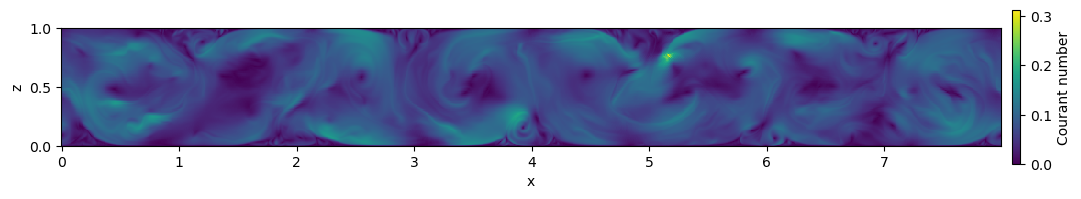

In [14]:
highRa = xr.open_mfdataset(
    '../data/restest_highRa_1024_128/*.nc', 
    chunks={'t': 1000, 'x': 128, 'z': 128})

def courant_number(data):
    diff_x = np.diff(data.x)
    dx = (
        np.concatenate([[diff_x[0]], diff_x])
        + np.concatenate([diff_x, [diff_x[-1]]])
    )/2
    diff_z = np.diff(data.z)
    dz = (
        np.concatenate([[diff_z[0]], diff_z])
        + np.concatenate([diff_z, [diff_z[-1]]])
    )/2
    C = np.sqrt(
        (np.abs(data.u)/np.atleast_2d(dx).T)**2
        + (np.abs(data.w)/np.atleast_2d(dz))**2
    )*data.timestep
    return C

fig, ax = plt.subplots(figsize=(12, 2), sharex=True)
mesh = ax.pcolormesh(
    highRa.x, highRa.z, courant_number(highRa.isel(t=769)).T, vmin=0)
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(aspect='equal', xlabel='x', ylabel='z')
fig.tight_layout()

Here is a close-up of the singularity:

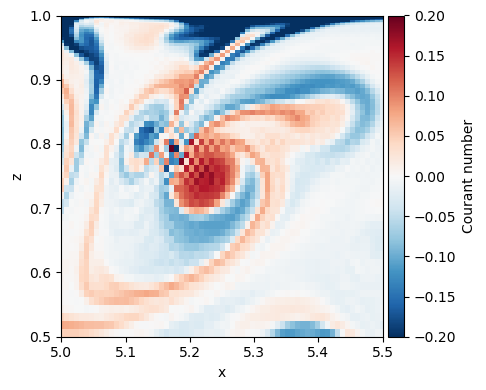

In [18]:
fig, ax = plt.subplots(figsize=(6, 4))
mesh = ax.pcolormesh(
    highRa.x, highRa.z, highRa.theta.isel(t=768).T,
    vmin=-0.2, vmax=0.2, cmap='RdBu_r')
fig.colorbar(mesh, ax=ax, pad=0.01, label='Courant number')
ax.set(
    aspect='equal', xlabel='x', ylabel='z', xlim=(5.0, 5.5), ylim=(0.5, 1.0))
fig.tight_layout()

## With hyperdiffusion: model crashes at $t = 1.97 \times 10^6$
I now add 4th-order hyperdiffusion terms $-\tilde{\nu} \nabla^4$ to the momentum and energy equations, choosing the hyperdiffusion coefficient $\tilde{\nu} = 10^{-7}$. In order to avoid needing to specify additional boundary conditions, the hyperdiffusion is reduced to zero at the boundaries using a factor $f(z) = 1 - (2z - 1)^{10}$. The equations in full are

$$
\begin{align*}
    \mathrm{Ra}\,\mathrm{Pr}^{-1} \left( \partial_t \vec{u} + \vec{u} \cdot \vec{\nabla} \vec{u} \right)
        &= -\vec{\nabla} \pi + \nabla^2 \vec{u} - \tilde{\nu} f(z) \nabla^4 \vec{u} + \theta \hat{z}, \\
    \mathrm{Ra} \left( \partial_t \theta + \vec{u} \cdot \vec{\nabla} \theta \right)
        &= \nabla^2 \theta - \tilde{\nu} f(z) \nabla^4 \theta, \\
    \vec{\nabla} \cdot \vec{u} &= 0
\end{align*}
$$

In [19]:
Video('../data/restest_highRa_hyper/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.mp4')

Checking the data in coefficient space confirms that there is an accumulation of power in the high-wavenumber modes at the point that the model crashes:

In [3]:
data = xr.open_dataset('../data/restest_highRa_hyper_1024_128/restest_highRa_hyper_1024_128_s1.nc')

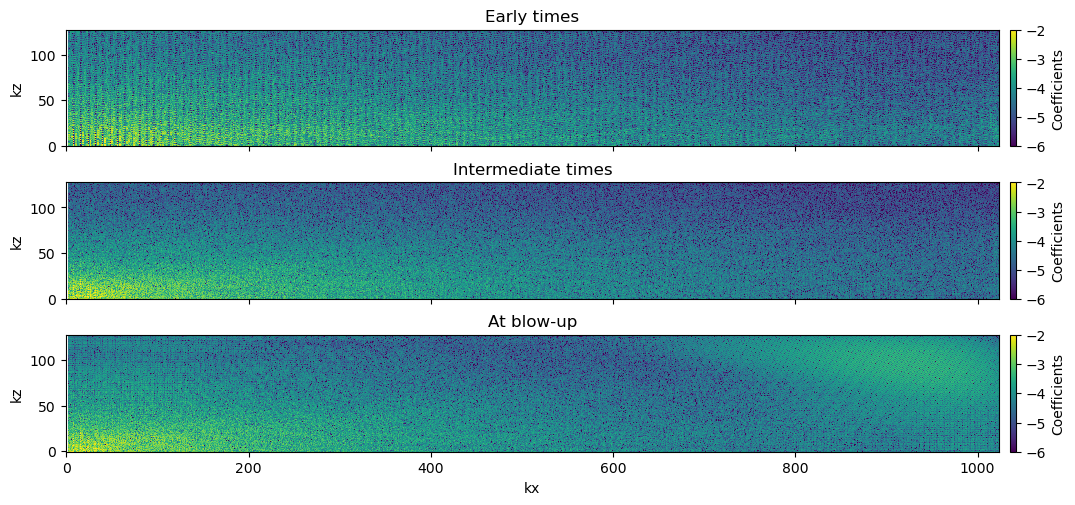

In [258]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

calculator = math.Math(1024, 128)

coef = calculator.space_coefficients(data.theta.isel(t=70))
mesh = axes[0].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[0], pad=0.01, label='Coefficients')
axes[0].set(aspect='equal', ylabel='kz', title='Early times')

coef = calculator.space_coefficients(data.theta.isel(t=600))
mesh = axes[1].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[1], pad=0.01, label='Coefficients')
axes[1].set(aspect='equal', ylabel='kz', title='Intermediate times')

coef = calculator.space_coefficients(data.theta.isel(t=656))
mesh = axes[2].pcolormesh(
    coef.kx, coef.kz, np.log10(np.abs(coef)).T, vmin=-6, vmax=-2)
fig.colorbar(mesh, ax=axes[2], pad=0.01, label='Coefficients')
axes[2].set(aspect='equal', xlabel='kx', ylabel='kz', title='At blow-up')

fig.tight_layout()


### Checking the magnitude of each term in the equations
To gain insight into the failure of the hyperdiffusion, I now calculate and plot each term contributing to $\partial_t u$, $\partial_t w$ and $\partial_t \theta$.

In [10]:
def laplacian(data):
    result = (
        data.differentiate('x').differentiate('x')
        + data.differentiate('z').differentiate('z')
    )
    return result

Rayleigh = 1e9
Prandtl = 1
hyper = 1e-7

def calculate_terms(i_time):
    u = data.u.isel(t=i_time)
    w = data.w.isel(t=i_time)
    theta = data.theta.isel(t=i_time)

    taper = 1 - (2*u.z - 1)**10

    u_terms = {
        'advection': (
            u * u.differentiate('x')
            + w * u.differentiate('z')
        ),
        'diffusion': laplacian(u)*Prandtl/Rayleigh,
        'hyperdiffusion': (
            hyper * taper * laplacian(laplacian(u))
        )*Prandtl/Rayleigh
    }
    w_terms = {
        'advection': (
            u * w.differentiate('x')
            + w * w.differentiate('z')
        ),
        'diffusion': laplacian(w)*Prandtl/Rayleigh,
        'hyperdiffusion': (
            hyper * taper * laplacian(laplacian(w))
        )*Prandtl/Rayleigh,
        'buoyancy': theta*Prandtl/Rayleigh
    }
    theta_terms = {
        'advection': (
            u * theta.differentiate('x')
            + w * theta.differentiate('z')
        ),
        'diffusion': laplacian(theta)/Rayleigh,
        'hyperdiffusion': (
            hyper * taper * laplacian(laplacian(theta))
        )/Rayleigh
    }
    return u_terms, w_terms, theta_terms


#### At early times

In [31]:
i_time = 70
u_terms, w_terms, theta_terms = calculate_terms(i_time)

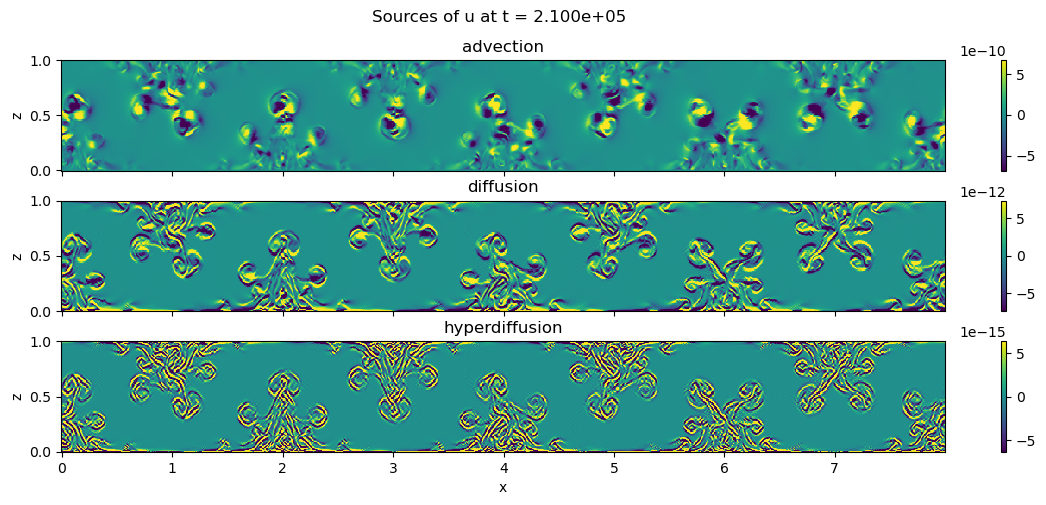

In [33]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

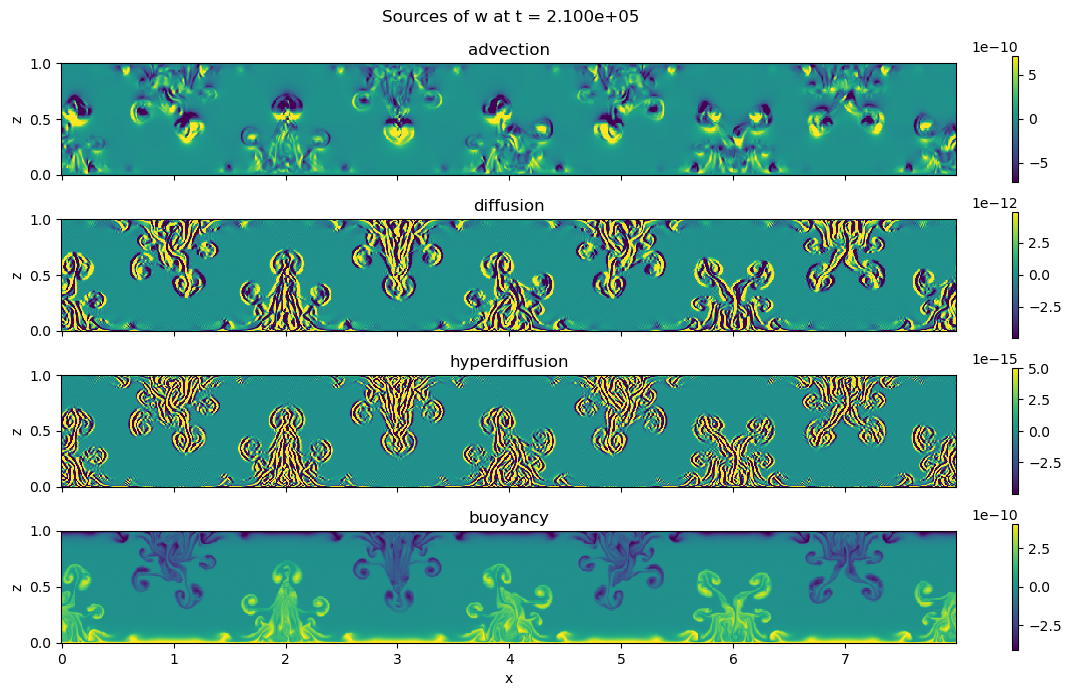

In [35]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.05]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

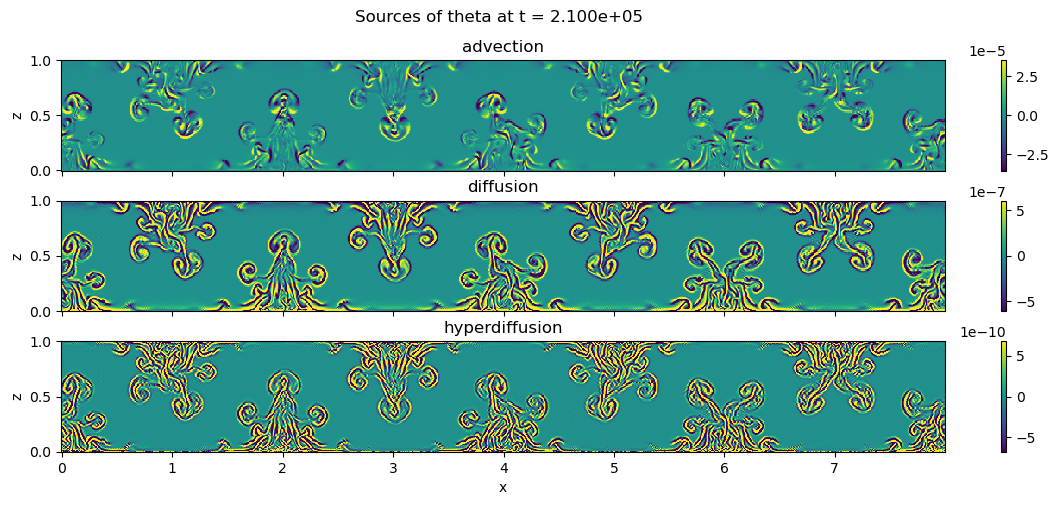

In [36]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

#### At intermediate times

In [37]:
i_time = 600
u_terms, w_terms, theta_terms = calculate_terms(i_time)

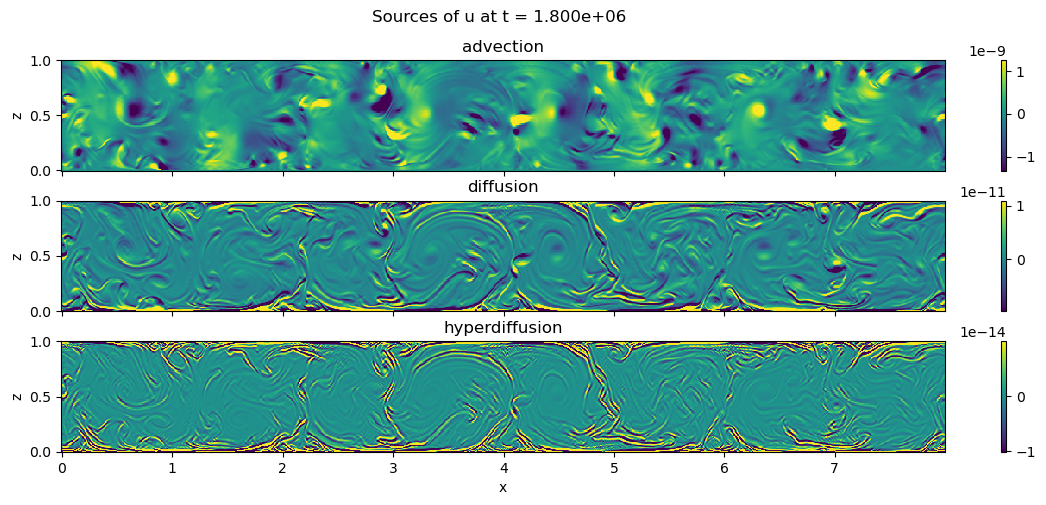

In [38]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

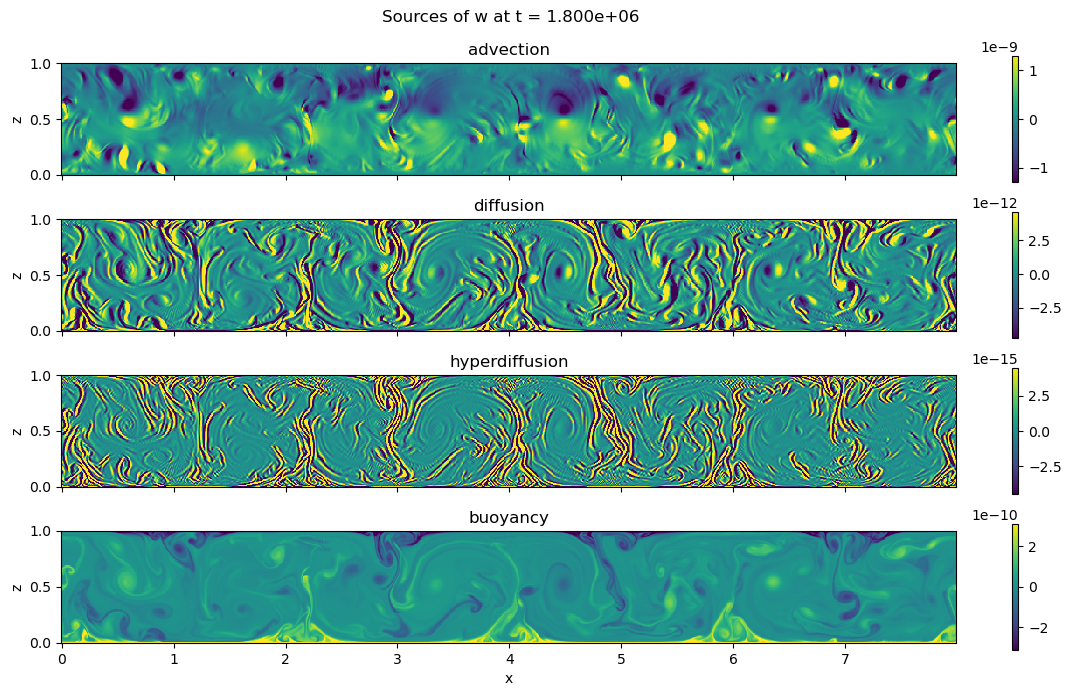

In [39]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.05]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

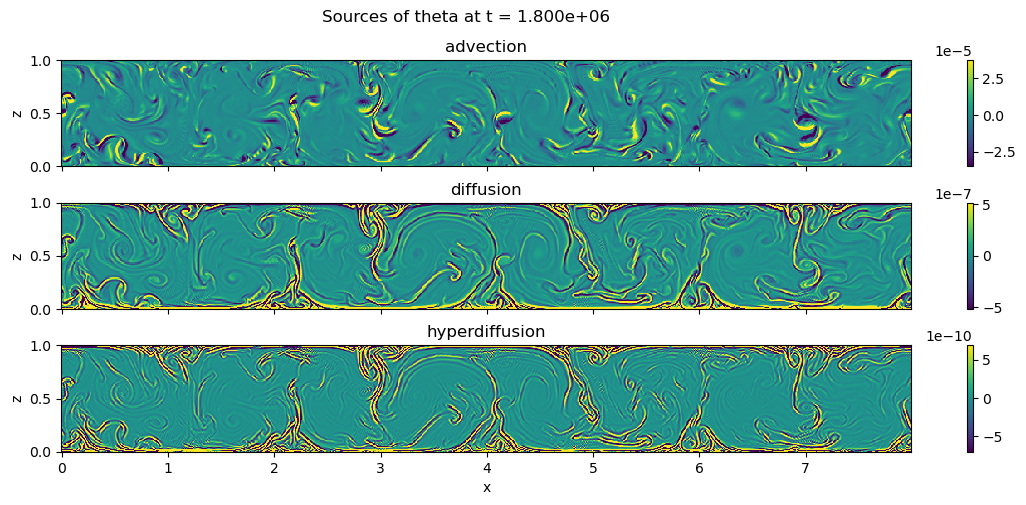

In [40]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

#### At blow-up

In [51]:
i_time = 656
u_terms, w_terms, theta_terms = calculate_terms(i_time)

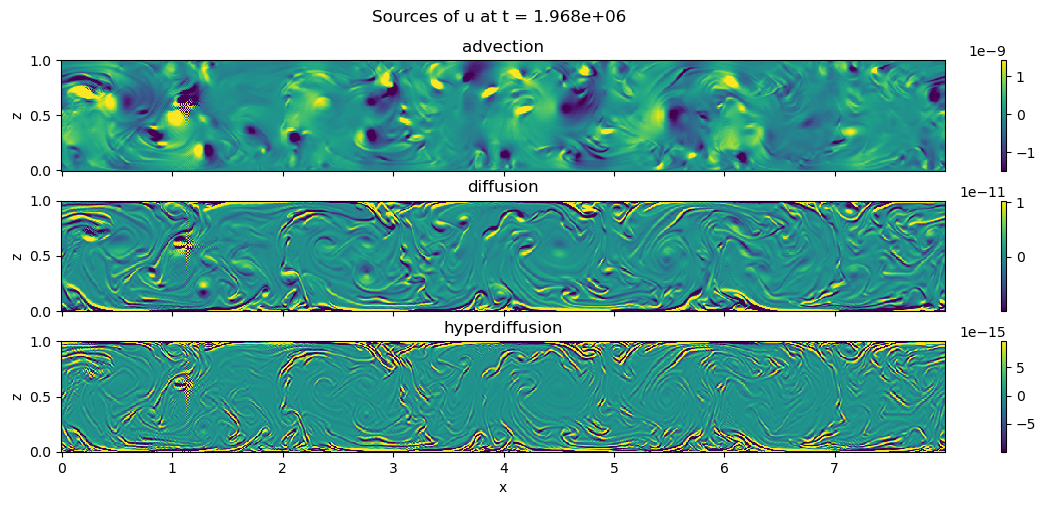

In [52]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(u_terms.keys()):
    array = u_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of u at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

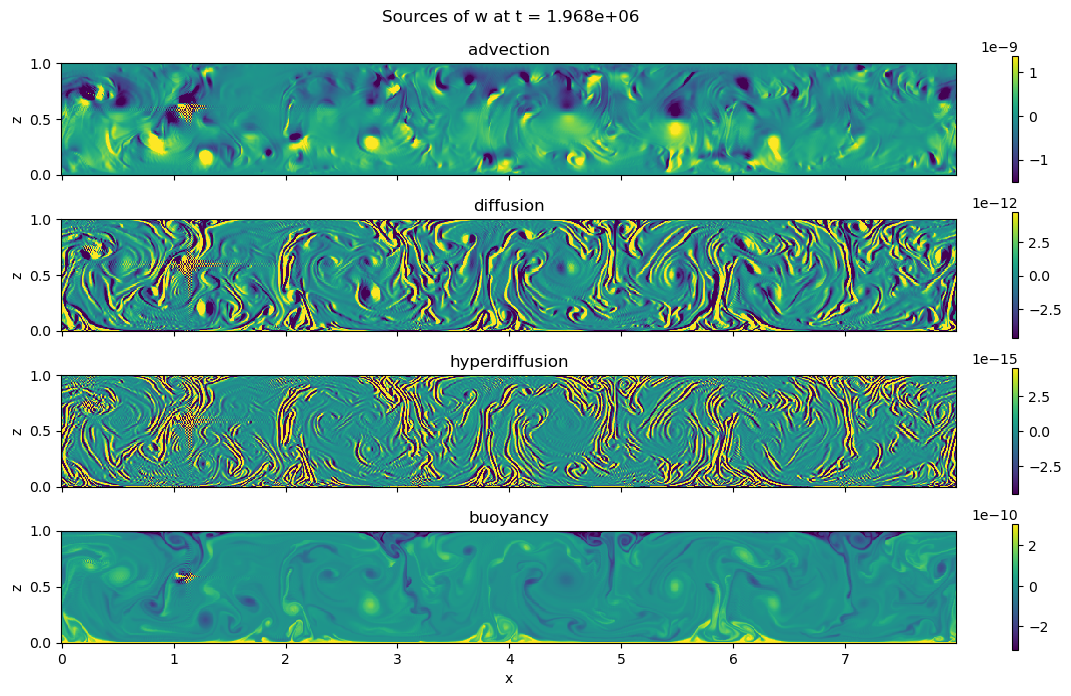

In [53]:
fig, axes = plt.subplots(4, 1, figsize=(12, 7), sharex=True)

quantiles = [0.01, 0.1, 0.1, 0.05]
for i, term in enumerate(w_terms.keys()):
    array = w_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of w at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

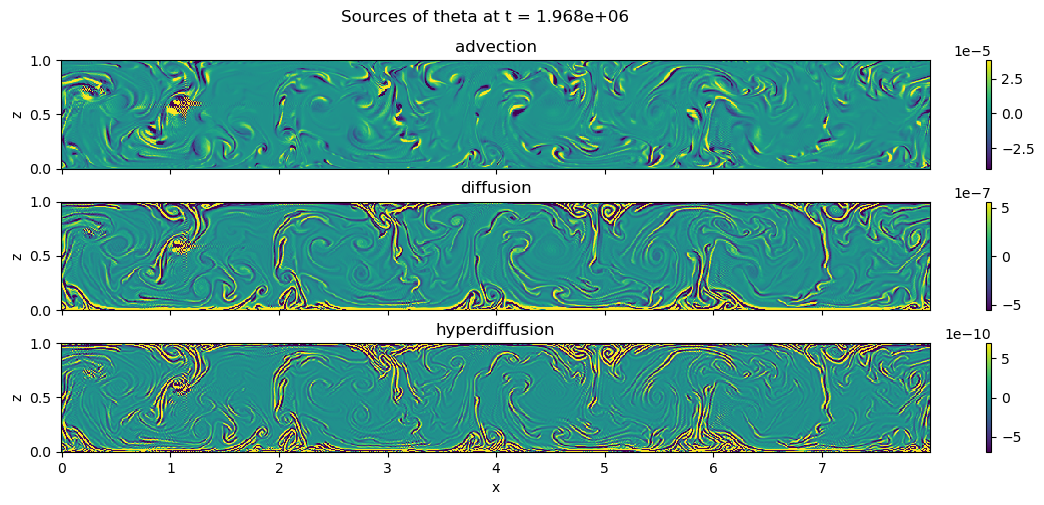

In [54]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

quantiles = [0.01, 0.1, 0.1]
for i, term in enumerate(theta_terms.keys()):
    array = theta_terms[term].transpose('z', 'x')
    mesh = axes[i].pcolormesh(array.x, array.z, array, shading='nearest')
    mesh.set_clim(
        np.quantile(array, quantiles[i]), np.quantile(array, 1 - quantiles[i]))
    axes[i].set(aspect='equal', ylabel='z', title=term)
    fig.colorbar(mesh, ax=axes[i])

axes[-1].set_xlabel('x')
fig.suptitle(f'Sources of theta at t = {data.t[i_time]:.3e}', x=0.43)
fig.tight_layout()

#### Hypothesis

Evidently, although the variables themselves are reasonably well-resolved, the spatial resolution may be insufficient to accurately resolve their derivatives. This could lead to artefacts in the derivative terms that cause the model to crasg. The hyperdiffusion would be the worst-affected, because it involved the highest derivative order (4). It is possible that the hyperdiffusion is not working because the fourth derivatives are not being accurately represented.